#### Project 3 - Triangular mesh generator

In [42]:
using PyPlot, LinearAlgebra, Delaunator

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

# Delaunay triangulation `t` of array of nodes `p`
delaunay(p) = collect.(triangulate(p).triangles)

delaunay (generic function with 1 method)

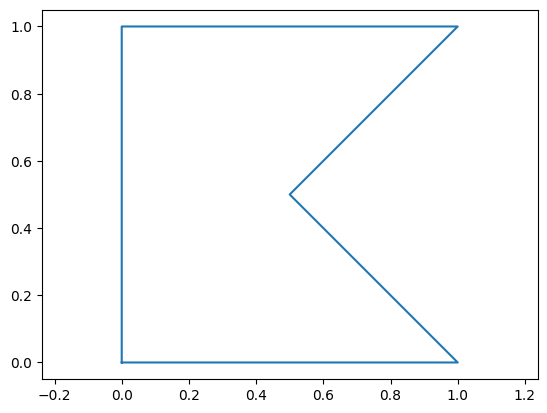

In [43]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

#### Problem 1 - Point in polygon

In [44]:
function inpolygon(p,pv)
    x,y = p[1],p[2]
    inside = false
    for i in 1:(length(pv)-1)
        xi = pv[i][1]
        yi = pv[i][2]
        xj = pv[i+1][1]
        yj = pv[i+1][2]
        if (((yi > y)!=(yj > y))&&(x < ((((xj - xi) * (y - yi)) / (yj - yi)) + xi)))
            inside = !inside
        end
    end
    return inside
end
inpolygon([0.8,0.3],pv)

false

#### Problem 2(a) - Triangle area

In [45]:
#given three point, we will calculate the area
tri = [[1,0.5], [2,1], [0,3]]
function tri_area(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    area = (1/2)*abs(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))
    return area
end
tri_area(tri)

1.5

#### Problem 2(b) - Triangle area

In [61]:
function tri_centroid(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    return [(1/3)*(x1+x2+x3),(1/3)*(y1+y2+y3)]
end
tri_centroid(tri)

2-element Vector{Float64}:
 1.0
 1.5

#### Problem 2(c) - Triangle circumcenter

In [60]:
#
function tri_circumcenter(tri)
    x1 = tri[1][1]
    y1 = tri[1][2]
    x2 = tri[2][1]
    y2 = tri[2][2]
    x3 = tri[3][1]
    y3 = tri[3][2]
    d = 2*(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))
    x = 1/d*((x1^2+y1^2)*(y2 - y3)+(x2^2+y2^2)*(y3-y1)+(x3^2+y3^2)*(y1-y2))
    y = 1/d*((x1^2+y1^2)*(x3 - x2)+(x2^2+y2^2)*(x1-x3)+(x3^2+y3^2)*(x2-x1))
    return [x,y] 
end
tri_centroid(tri)

2-element Vector{Float64}:
 0.9166666666666666
 1.9166666666666665

#### Problem 3 - Mesh generator

this triangle will be deleted: Any[[0.5, 0.5], [0.6414213562373094, 0.6414213562373094], [0.717157287525381, 0.282842712474619]]
this triangle will be deleted: Any[[0.6414213562373094, 0.6414213562373094], [0.782842712474619, 0.782842712474619], [0.717157287525381, 0.282842712474619]]
this triangle will be deleted: Any[[0.782842712474619, 0.782842712474619], [0.8585786437626906, 0.14142135623730945], [0.717157287525381, 0.282842712474619]]
this triangle will be deleted: Any[[1.0, 1.0], [1.0, -0.0], [0.8585786437626906, 0.14142135623730945]]
this triangle will be deleted: Any[[1.0, 1.0], [0.8585786437626906, 0.14142135623730945], [0.782842712474619, 0.782842712474619]]


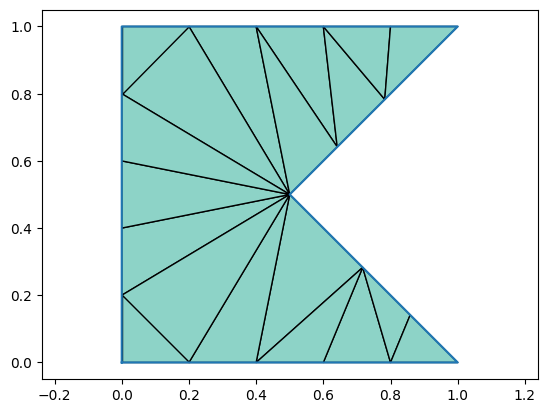

2-element Vector{Float64}:
 0.860947570824873
 0.9276142374915396

In [62]:
using LinearAlgebra
using Delaunator


#given two points a and b of coordinate [x1,y1],[x2,y2], we will calculate the y coordinate
#of the given corresponding x on the line segment ab.
function y_coord(a,b,x)
    x1 = a[1]
    y1 = a[2]
    x2 = b[1]
    y2 = b[2]
    y = (x-x1+y1*(x2-x1)/(y2-y1))*((y2-y1)/(x2-x1))
    return y
end

#given the two point and the y coordinate, return the x coordinate on the edge
function x_coord(a,b,y)
    x1 = a[1]
    y1 = a[2]
    x2 = b[1]
    y2 = b[2]
    x = (y-y1)*(x2-x1)/(y2-y1)+x1
    return x
end

#this return the length between two points
function cartesion_distance(a,b)
    return sqrt((b[1]-a[1])^2+(b[2]-a[2])^2)
end

#We will first create node points p along each polygon segment and store them in node(it will also include the polygon node), 
#separated by a distance approximately equal to hmax. Return all the node on the line
function equi_node(pv,hmax)
    node = []
    for i in 1:(length(pv)-1)
        if (pv[i+1][1]-pv[i][1] !=0)&(pv[i+1][2]-pv[i][2] != 0) #this is when the edge is neigher horizental nor veritical
            #println("neigher vertical nor horizental")
            dx = hmax*(pv[i+1][1]-pv[i][1])/cartesion_distance(pv[i+1],pv[i])
            #println("dx : ", dx)
            xarray = collect(pv[i][1]:dx:(pv[i+1][1]-dx))
            #println("the x array is ", xarray)
            yarray = []
            for x in xarray
                push!(yarray,y_coord(pv[i],pv[i+1],x))
            end
            #println("the y array is ", yarray)
            #if length(xarray) != length(yarray)
            #    println("ok this is not solving the problem")
            #end
            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
        elseif ((pv[i+1][1]-pv[i][1] == 0)&(pv[i+1][2]-pv[i][2] != 0)) #this is when the edge is veritical
            #println("vertical")
            dy = hmax*(pv[i+1][2]-pv[i][2])/cartesion_distance(pv[i+1],pv[i])
            #println("dy : ", dy)
            yarray = collect(pv[i][2]:dy:(pv[i+1][2]-dy))
            xarray = []
            #if length(xarray) != length(yarray)
            #    println("ok this is not solving the problem")
            #end
            for y in yarray
                push!(xarray,pv[i][1])
            end
            #println("the x array is ", xarray)
            #println("the y array is ", yarray)

            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
        elseif (pv[i+1][2]-pv[i][2] == 0)&(pv[i+1][1]-pv[i][1] !=0) #this is when the line is horizental
            #println("horizental")
            dx = hmax*(pv[i+1][1]-pv[i][1])/cartesion_distance(pv[i+1],pv[i])
            #println("dx : ", dx)
            xarray = collect(pv[i][1]:dx:(pv[i+1][1]-dx))
            #println("the x array is ", xarray)
            yarray = []
            for x in xarray
                push!(yarray,pv[i][2])
            end
            #println("the y array is ", yarray)
            #if length(xarray) != length(yarray)
            #    println("ok this is not solving the problem")
            #end
            for j in 1:length(xarray)
                push!(node,[xarray[j],yarray[j]])
            end
            
        end
    end
    push!(node,pv[1])
    return node
end

#remove triangle ouside of a polygon
function remove_tri(p,t,pv)
    new_t = []
    #tri = [p[t[i]] for i in 1:length(t)]
    tri = tri_centroid.([p[t[i]] for i in 1:length(t)])
    for c in 1:length(tri)
        if inpolygon(tri[c],pv)
            push!(new_t,t[c])
        end
        if !inpolygon(tri[c],pv)
            println("this triangle will be deleted: ", p[t[c]])
        end
    end

    return new_t
end

function pmesh(pv,hmax)
    terminate = true

    #Create node points p along each polygon segment, separated by a distance approximately equal to hmax.
    p = equi_node(pv,hmax) 

    #Triangulate the domain using the delaunay function.
    t = delaunay(p)

    #Remove the triangles outside the polygon, by computing all the triangle centroids (using tri_centroid) and determining if they are inside (using inpolygon).
    for i in 1:length(t)
        tri = p[t[i]]
        if inpolygon(tri_centroid(tri),pv)
            println("")
            deleteat!(t,i)
        end
    end

    while terminate

        #if maximum(tri_area())

        #end

    end

end
pv = [[0,0], [1,0], [0.5,0.5], [1,1], [0,1], [0,0]]
#pv = [[i/10,0.1*(-1)^i] for i = 0:10]
#append!(pv, [[.5,.6], [0,.1]])
p = equi_node(pv,0.2)
#display(node)
#x_coord([0.5,0.5],[1,1],0.5)
plot(first.(p), last.(p))
#axis("equal");
t = delaunay(p)
#tplot(p,t)

t = remove_tri(p,t,pv)
tplot(p,t)
#inpolygon(tri_centroid([[0.8, 1.0], [1.0, 1.0], [0.782842712474619, 0.782842712474619]]),pv)
#tri_centroid([[0.8, 1.0], [1.0, 1.0], [0.782842712474619, 0.782842712474619]])